Dataset and problem statement: "https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29" <br>
Code obtained from: <br>

Title: "Neural Networks from Scratch in Python" <br>
Authors: Harrison Kinsley & Daniel Kukieła <br>
Publisher: Harrison Kinsley, 2020

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting Functions

In [78]:
def plot_acc_error(arr,title,len=5001):
    fig,ax = plt.subplots()

    ax.plot(np.array(range(0,len,100))[1:],1-np.array(arr)[1:])
    ax.set_title(title)
    ax.set_ylabel("Percentage error")
    ax.set_xlabel('Epochs')
    plt.show()

# Fully Connected Layer

In [3]:
class Layer_FC: # Dense/fully connected

    def __init__(self,num_inputs,num_neurons):
        self.weights = 0.01*np.random.randn(num_inputs,num_neurons)
        self.biases = np.zeros((1,num_neurons))

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases

    def backward(self,dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues,self.weights.T)

# Activation Functions - Rectilinear and Softmax

In [4]:
# Rectilinear activation function
class Activation_ReLU:

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)

    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation for classification
class Activation_Softmax:

    def forward(self,inputs):
        # We take the subtraction of the max of the inputs to avoid "exploding values" and "dead neurons"
        exps = np.exp(inputs - np.max(inputs,axis=1,keepdims=True)) 
        probabilities = exps/np.sum(exps,axis=1,keepdims=True)
        self.output = probabilities

    def backward(self,dvalues):
        # Uninitialised array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index,(single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            # Flatten output array 
            single_output = single_output.reshape(-1,1)  # coloumn matrix
            jacobian = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            # Calculate the sample-wise gradient and add to array of sample gradients
            self.dinputs[index] = np.dot(jacobian,single_dvalues)

# Loss Functions

In [5]:
class Loss:
    
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

# Inherits Loss
class Loss_CategoricalCrossEntropy(Loss): 

    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        # CLip to prevent division by zero and clip both sides to drage mean to any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped* y_true,
                axis=1
            )
        # Losses
        negative_log_probabs = -np.log(correct_confidences)
        return negative_log_probabs
    
    def backward(self, dvalues, y_true): ### We gonna only use one sample... use integer encoding instead
        samples = len(dvalues)
        # Number of labels in every sample, we use the first one to count ????
        lables = len(dvalues[0])
        # If lables are sparse, turn them into one-hot vector??
        if len(y_true.shape) == 1:
            y_true = np.eye(lables)[y_true]
        # Calculate gradient
        self.dinputs = -y_true/dvalues
        # Normalise gradient
        self.dinputs = self.dinputs/samples


class Activation_Softmax_Loss_CategoryCrossEntropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()
        
    def forward(self,inputs,y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        self.output = self.activation.output ### ??????????????????
        # Calculate and return loss value
        return self.loss.calculate(self.output,y_true)
    
    def backward(self, dvalues, y_true): ### We gonna only use one sample... use integer encoding instead
        samples = len(dvalues)
        # If lables are one-hot encoded, turn them  into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples),y_true] -= 1
        # Normalise gradient
        self.dinputs = self.dinputs/samples

# Minimisation Methods:

Regular line-search: <br>
$\bold{x}^{k+1}=\bold{x}^{k}+s^k \bold{d}^k$ <br>
$s^{k+1}=s^{k}(1+\alpha k)^{-1}$<br>
where $\bold{x}$ are the domain values (weights and biases), $s$ is the step-size (learning rate), $\alpha$ is the decay rate and $\bold{d}$ is the $f'(\bold{x})$ <br>
<br>
With momentum: <br>
$\bold{x}^{k+1}=\bold{x}^{k} + \bold{p}^k$ <br>
$\bold{p^{k+1}} = \gamma \bold{p}^{k} +s^k \bold{d}^k$ <br>
$\gamma$ is the fraction of previous search direction, with the momentums of the inputs correspond to $\bold{p}$. Initially, $\bold{p}^0=\bold{0}$ <br>

In [79]:
# Minimiser using line-search methods
# x = x + s*grad(f(x))
class Optimizer:
    # Learning rate: stepsize = s
    # decay: reducing factor of stepsize (decay)

    # Call once, before any parameter update
    def pre_update_params(self):
        # Checks if decay is not zero
        if self.decay:
            self.current_s = self.current_s*(1/(1 + self.decay * self.iterations))
            # curr_lr = curr_lr (1+)
    def post_update(self):
        self.iterations += 1

#### Stochastic Gradient Descent

In [6]:
# Inherits 'Optimizer'
class SGD(Optimizer):

    def __init__(self, s, decay, momentum):
        self.s = s
        self.curr_s = s
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def update_params(self,layer):
        # if we decide to select a momentum that is not zero
        if self.momentum:
            # The update contains a portion of the gradient from preceding steps as our momentum (direction of previous changes) 
            # and only a portion of the current gradient; together, these portions form the actual change to our parameters
    
            # If layer does not contain momentum arrays, create them filled with zeros of same shape as layer
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            # Build weight update with momentum
            weight_update = self.momentum*layer.weight_momentums - self.curr_s*layer.dweights
            layer.weight_momentums = weight_update
            # Build bias update 
            bias_update = self.momentum*layer.bias_momentums - self.curr_s*layer.dbiases
            layer.bias_momentums = bias_update 
        # Vanilla SGD, without momentum
        else: 
            weight_update = -self.curr_s*layer.dweights
            bias_update = -self.curr_s*layer.dbiases
        # Update weights and biases
        layer.weights += weight_update
        layer.biases += bias_update


#### AdaGrad

In [60]:
class AdaGrad(Optimizer):

    def __init__(self, s=2, decay=0, ε=1e-7):
        self.s = s
        self.curr_s = s
        self.decay = decay
        self.iterations = 0
        self.ε = ε

    def update_params(self,layer):   
        # If layer does not contain momentum arrays, create them filled with zeros of same shape as layer, same for bias_momentum
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        # Vanilla SGD param update + normalisation with square root cache
        layer.weights += -self.curr_s*layer.dweights/(np.sqrt(layer.weight_cache)+self.ε)
        layer.biases += -self.curr_s*layer.dbiases/(np.sqrt(layer.bias_cache)+self.ε)
    

#### Root Mean Square Propagation 

In [73]:
class RMSP(Optimizer):

    def __init__(self, s=0.001, decay=1e-4, ε=1e-7, ρ=0.9):
        self.curr_s = s
        self.s = s
        self.decay = decay
        self.iterations = 0
        self.ε = ε 
        self.ρ = ρ
    
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.ρ*layer.weight_cache + (1 - self.ρ)*layer.dweights**2
        layer.bias_cache = self.ρ*layer.bias_cache + (1 - self.ρ)*layer.dbiases**2

        layer.weights += -self.curr_s*layer.dweights/(np.sqrt(layer.weight_cache) + self.ε)
        layer.biases += -self.curr_s*layer.dbiases/(np.sqrt(layer.bias_cache) + self.ε)

# Parameters to tinker with

In [50]:
# Number of neurons
hidden_neurons = 64
# SGD parameters
learning_rate = 0.02
decay = 0 # -----> Convergence is quicker with no decay
momentum = 0.2 # ------> Convergence is quicker with smaller fractional value but not too small

# Setting up the Model

In [74]:
# Open and read file
trainingFile = open('shuttle.trn','r')
lines = trainingFile.readlines()
batch = np.zeros((len(lines),9))
classfy = np.zeros(len(lines))

# Set up input as a 2d array
for i in range(len(lines)):
    temp_str = lines[i].split(' ')
    classfy[i] = int(temp_str[-1])
    for j in range(9):
        batch[i,j] = int(temp_str[j])
        
# Change category counting to start from 0 and convert to int
classfy = np.asarray(classfy, dtype = 'int') - 1

input_layer = Layer_FC(9,hidden_neurons)
activation1 = Activation_ReLU()

layer2 = Layer_FC(hidden_neurons,7)
loss_activation = Activation_Softmax_Loss_CategoryCrossEntropy()
    

# Training Model with Stochastic Gradient Descent

In [52]:
# Initialise storage arrays
SGD_acc = []
# Select Optimizer
optimizer = SGD(learning_rate,decay,momentum)
for epoch in range(5001):
    # Forward pass, for activation function too
    input_layer.forward(batch)
    activation1.forward(input_layer.output)
    # Forward pass on second layer, input is output of first layer (the activation output)
    layer2.forward(activation1.output)
    # Forward pass through activation/loss function 
    # Takes output of second layer and returns loss
    loss = loss_activation.forward(layer2.output,classfy)
    # Calculate the accuracy from output of activation2 and targets, along first axis
    predictions = np.argmax(loss_activation.output,axis=1)

    accuracy = np.mean(predictions==classfy)
    if not epoch % 100:
        SGD_acc.append(accuracy)
        # print(f'epoch:{epoch},'+
        #       f'acc:{accuracy},'+
        #       f'loss:{loss:.3f},'+
        #       f'lr:{optimizer.current_learning_rate}')
    # Backward pass
    loss_activation.backward(loss_activation.output,classfy)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    input_layer.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(input_layer)
    optimizer.update_params(layer2)
    optimizer.post_update()

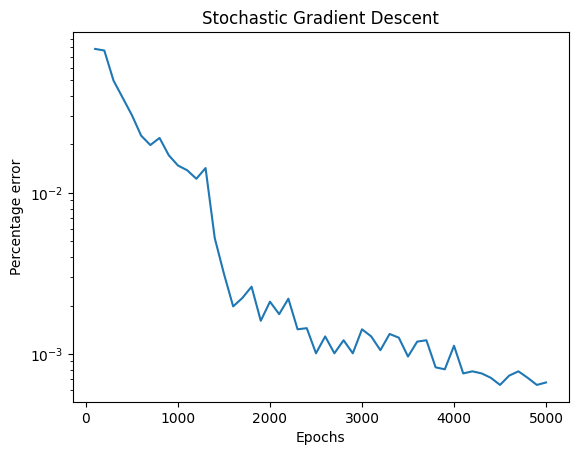

In [69]:
fig,ax = plt.subplots()

ax.plot(np.array(range(0,5001,100))[1:],1-np.array(SGD_acc)[1:])
ax.set_title("Stochastic Gradient Descent")
ax.set_yscale('log')
ax.set_ylabel("Percentage error")
ax.set_xlabel('Epochs')
plt.show()

# Training Model with AdaGrad 

In [62]:
# Initialise storage arrays
AdaGrad_acc = []
# Select Optimizer
optimizer = AdaGrad()
for epoch in range(5001):
    # Forward pass, for activation function too
    input_layer.forward(batch)
    activation1.forward(input_layer.output)
    # Forward pass on second layer, input is output of first layer (the activation output)
    layer2.forward(activation1.output)
    # Forward pass through activation/loss function 
    # Takes output of second layer and returns loss
    loss = loss_activation.forward(layer2.output,classfy)
    # Calculate the accuracy from output of activation2 and targets, along first axis
    predictions = np.argmax(loss_activation.output,axis=1)

    accuracy = np.mean(predictions==classfy)
    if not epoch % 100:
        AdaGrad_acc.append(accuracy)
        print(f'epoch:{epoch},'+
              f'acc:{accuracy},'+
              f'loss:{loss:.3f},'+
              f'lr:{optimizer.current_learning_rate}')
    # Backward pass
    loss_activation.backward(loss_activation.output,classfy)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    input_layer.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(input_layer)
    optimizer.update_params(layer2)
    optimizer.post_update()

epoch:0,acc:0.012206896551724139,loss:1.959,lr:2
epoch:100,acc:0.9139080459770115,loss:0.326,lr:2
epoch:200,acc:0.9740689655172414,loss:0.235,lr:2
epoch:300,acc:0.9836551724137931,loss:0.112,lr:2
epoch:400,acc:0.992551724137931,loss:0.091,lr:2
epoch:500,acc:0.993632183908046,loss:0.063,lr:2
epoch:600,acc:0.9948045977011494,loss:0.056,lr:2
epoch:700,acc:0.9957241379310345,loss:0.051,lr:2
epoch:800,acc:0.9949655172413793,loss:0.048,lr:2
epoch:900,acc:0.9964597701149426,loss:0.031,lr:2
epoch:1000,acc:0.996,loss:0.036,lr:2
epoch:1100,acc:0.996,loss:0.035,lr:2
epoch:1200,acc:0.985103448275862,loss:0.039,lr:2
epoch:1300,acc:0.984551724137931,loss:0.039,lr:2
epoch:1400,acc:0.9969655172413793,loss:0.020,lr:2
epoch:1500,acc:0.9961609195402299,loss:0.029,lr:2
epoch:1600,acc:0.9968965517241379,loss:0.019,lr:2
epoch:1700,acc:0.9953333333333333,loss:0.031,lr:2
epoch:1800,acc:0.9975862068965518,loss:0.014,lr:2
epoch:1900,acc:0.997264367816092,loss:0.018,lr:2
epoch:2000,acc:0.9972183908045977,loss:0.

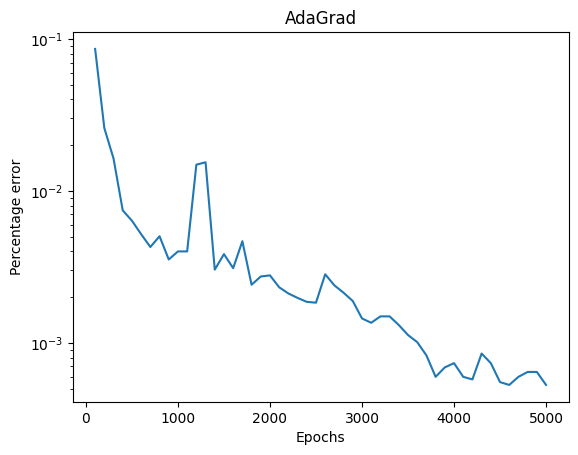

In [67]:
fig,ax = plt.subplots()

ax.plot(np.array(range(0,5001,100))[1:],1-np.array(AdaGrad_acc)[1:])
ax.set_title("AdaGrad")
ax.set_yscale('log')
ax.set_ylabel("Percentage error")
ax.set_xlabel('Epochs')
plt.show()

# Training Model with Root Mean Square Propagation

In [75]:
# Initialise storage arrays
RMSP_acc = []
# Select Optimizer
optimizer = RMSP()
for epoch in range(5001):
    # Forward pass, for activation function too
    input_layer.forward(batch)
    activation1.forward(input_layer.output)
    # Forward pass on second layer, input is output of first layer (the activation output)
    layer2.forward(activation1.output)
    # Forward pass through activation/loss function 
    # Takes output of second layer and returns loss
    loss = loss_activation.forward(layer2.output,classfy)
    # Calculate the accuracy from output of activation2 and targets, along first axis
    predictions = np.argmax(loss_activation.output,axis=1)

    accuracy = np.mean(predictions==classfy)
    if not epoch % 100:
        RMSP_acc.append(accuracy)
        print(f'epoch:{epoch},'+
              f'acc:{accuracy},'+
              f'loss:{loss:.3f},'+
              f'lr:{optimizer.current_learning_rate}')
    # Backward pass
    loss_activation.backward(loss_activation.output,classfy)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    input_layer.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(input_layer)
    optimizer.update_params(layer2)
    optimizer.post_update()

epoch:0,acc:0.7264367816091954,loss:1.878,lr:0.001
epoch:100,acc:0.9285287356321839,loss:0.217,lr:0.0006105675350281858
epoch:200,acc:0.9542068965517242,loss:0.140,lr:0.00013849833930748714
epoch:300,acc:0.9631954022988506,loss:0.126,lr:1.1785522069691256e-05
epoch:400,acc:0.9635402298850575,loss:0.125,lr:3.798226529160479e-07
epoch:500,acc:0.9635402298850575,loss:0.125,lr:4.6794578436187545e-09


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots()

ax.plot(np.array(range(0,5001,100))[1:],1-np.array(RMSP_acc)[1:])
ax.set_title("Stochastic Gradient Descent")
ax.set_ylabel("Percentage error")
ax.set_xlabel('Epochs')
plt.show()

# Testing Model on Unseen data

In [54]:
# Open and read file
test_file = open('shuttle.tst','r')
lines_tst = test_file.readlines()
batch_tst = np.zeros((len(lines_tst),9))
classfy_tst = np.zeros(len(lines_tst))

# Set up input as a 2d array
for i in range(len(lines_tst)):
    temp_str = lines_tst[i].split(' ')
    classfy_tst[i] = int(temp_str[-1])
    for j in range(9):
        batch_tst[i,j] = int(temp_str[j])

# Change category counting to start from 0 and convert to int
classfy_tst = np.asarray(classfy_tst, dtype = 'int') - 1
# Forward pass
input_layer.forward(batch_tst)
activation1.forward(input_layer.output)
layer2.forwardx(activation1.output)
# Calculate loss
loss = loss_activation.forward(layer2.output,classfy_tst)
predictions = np.argmax(loss_activation.output,axis=1)
accuracy = np.mean(predictions==classfy_tst)
print(f'validation => acc:{accuracy:.3f},loss:{loss:.3f}')


validation,acc:0.998,loss:0.009


array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000])